In [1]:
!dir

 Volume in drive D is SSD Groá
 Volume Serial Number is E892-64DB

 Directory of D:\Projects\Kaggle_8_Hacking_the_Kidney\working

30/04/2021  22:25    <DIR>          .
30/04/2021  22:25    <DIR>          ..
16/04/2021  17:49    <DIR>          .ipynb_checkpoints
30/04/2021  17:04           395.953 infer.ipynb
12/04/2021  21:43               513 kernel-metadata.json
26/04/2021  23:26           747.154 predict.ipynb
29/04/2021  00:58         2.892.475 process.ipynb
29/04/2021  22:00           584.780 submission.csv
30/04/2021  22:25           538.059 train.ipynb
               6 File(s)      5.158.934 bytes
               3 Dir(s)  165.267.361.792 bytes free


In [2]:
import os
import tensorflow as tf
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5674302668287603817
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22721396736
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14938263832054576889
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:09:00.0, compute capability: 8.6"
]


In [3]:
%env SM_FRAMEWORK=tf.keras
import warnings
warnings.filterwarnings("ignore")
import os
import gc
import cv2
import json
import time
import random
import numpy as np
import pandas as pd
import tifffile as tiff
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import albumentations as albu
from sklearn.model_selection import train_test_split, KFold, GroupKFold, StratifiedKFold
import tensorflow.keras.backend as K
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import *
import segmentation_models as sm
from segmentation_models import Unet, FPN, Linknet, PSPNet
from segmentation_models.losses import bce_jaccard_loss
from tqdm.notebook import tqdm
from glob import glob
print("tensorflow version:", tf.__version__)
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
if gpu_devices:
    for gpu_device in gpu_devices:
        print("device available:", gpu_device)
pd.set_option("display.max_columns", None)
%matplotlib inline

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.
tensorflow version: 2.6.0-dev20210407
device available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
pd.read_csv("../models/results.csv", index_col = 0)

,version,folds,img_size,resize,batch_size,epochs,patience,backbone,loss,mirror,umodel,bce_weight,shift,pseudo,lr,best_epoch,best_loss,best_dice_coef,split,seed,bavg_epoch,bavg_loss,bavg_dice_coef,dice_by_folds,mixed_precision,aughard,norm,bnw,weights,triple,reduce_dims
0,6,1,256,1,20,30,20,efficientnetb7,bce_dice,False,unet,1.0,True,NaN,0.0002,25.0,0.004156,0.894248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13,4,256,1,32,40,20,efficientnetb7,bce_dice,False,unet,1.0,True,NaN,0.0002,NaN,NaN,NaN,kfold,NaN,15.500000,0.236562,0.454637,0.6554 0.4974 0.5797 0.0861,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14,4,256,4,32,40,20,efficientnetb7,bce_dice,False,unet,1.0,True,NaN,0.0010,NaN,NaN,NaN,kfold,NaN,24.666667,NaN,NaN,nan 0.2318 0.3154,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,22,1,256,4,64,1,20,efficientnetb0,bce_dice,False,unet,1.0,True,NaN,0.0001,NaN,NaN,NaN,dont,NaN,0.000000,0.516637,0.077527,0.0775,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,24,1,256,4,32,20,20,efficientnetb0,bce_dice,False,unet,1.0,True,NaN,0.0001,NaN,NaN,NaN,dont,42.0,15.000000,0.027320,0.777308,0.7773,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,25,1,256,4,32,20,20,efficientnetb0,bce_dice,False,unet,1.0,True,NaN,0.0001,NaN,NaN,NaN,dont,42.0,19.000000,0.019676,0.884997,0.8850,False,NaN,NaN,NaN,NaN,NaN,NaN
6,17,4,256,4,16,30,20,efficientnetb5,bce_dice,False,unet,1.0,True,NaN,0.0002,NaN,NaN,NaN,kfold,NaN,13.000000,0.083721,0.637541,0.8200 0.8174 0.1290 0.7837,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,27,1,256,4,32,20,10,efficientnetb0,bce_dice,False,unet,1.0,True,NaN,0.0001,NaN,NaN,NaN,dont,69.0,16.000000,0.033654,0.662921,0.6629,True,NaN,NaN,NaN,NaN,NaN,NaN
8,31,1,256,4,32,20,10,efficientnetb0,bce_dice,False,unet,1.0,True,NaN,0.0001,NaN,NaN,NaN,dont,69.0,11.000000,0.073768,0.667674,0.6677,True,NaN,NaN,NaN,NaN,NaN,NaN
9,26,1,256,4,32,100,10,efficientnetb0,bce_dice,False,unet,1.0,True,NaN,0.0001,NaN,NaN,NaN,dont,42.0,46.000000,0.025203,0.899880,0.8999,False,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 2080 Ti (UUID: GPU-9719cbce-a56b-1f7d-efd5-519baafcfaef)
GPU 1: NVIDIA GeForce RTX 3090 (UUID: GPU-0b211566-f864-21f7-b80e-db06ced5fe0d)


In [6]:
MDLS_PATH = "../models"
if not os.path.exists(f"{MDLS_PATH}/results.csv"):
    VER = 1
else:
    results = pd.read_csv(f"{MDLS_PATH}/results.csv")
    VER = int(results.version.max())

PARAMS = {
    "version": VER,
    "folds": 5,
    "img_size": 512,
    "resize": 4,
    "batch_size" : 8,
    "epochs": 1000,
    "patience": 20,
    "backbone": "efficientnetb7",# efficientnetbX, 'inceptionv3', resnet34/50, resnext50, seresnet34, seresnext
    "loss": "bce_jaccard_loss",
    "mirror": False,
    "umodel" : "unet",  #  "unet", "fpn", "link", "psp"
    "bce_weight": 1.,
    "shift": True,
    "pseudo":"",
    "lr": 0.0002,
    "split": "dont", #kfold, dont, strat
    "seed": 69,
    "mixed_precision": True,
    "aughard": True,
    "norm": True,
    "bnw": True,
    "triple": True,
    "reduce_dims": False
}
size = PARAMS["img_size"]
DATA_PATH = "../input/hubmap-kidney-segmentation"

if PARAMS["mixed_precision"]:
    policy = tf.keras.mixed_precision.Policy("mixed_float16")
    tf.keras.mixed_precision.set_global_policy(policy)

IMGS_PATH = f"{DATA_PATH}/tiles_r{PARAMS['resize']}_s{PARAMS['img_size']}"
MSKS_PATH = f"{DATA_PATH}/masks_r{PARAMS['resize']}_s{PARAMS['img_size']}"

if PARAMS["norm"]:
    IMGS_PATH += "_norm"
    MSKS_PATH += "_norm"
    
if PARAMS["bnw"]:
    IMGS_PATH += "_bnw"
    MSKS_PATH += "_bnw"
    
if PARAMS["triple"]:
    IMGS_PATH += "_triple"
    MSKS_PATH += "_triple"

MDL_PATH = f"{MDLS_PATH}/models_v{VER:03}"
while os.path.exists(MDL_PATH):
    print("path already taken")
    VER += 1
    MDL_PATH = f"{MDLS_PATH}/models_v{VER:03}"
PARAMS["version"] = VER
os.mkdir(MDL_PATH)
with open(f"{MDL_PATH}/params.json", "w") as file:
    json.dump(PARAMS,file)
        

if not PARAMS["mirror"]:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    STRATEGY = tf.distribute.get_strategy()
else:
    STRATEGY = tf.distribute.MirroredStrategy()
    
def seed_all(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_all(PARAMS["seed"])
    
start_time = time.time()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6
path already taken
path already taken
path already taken
path already taken
path already taken
path already taken
path already taken
path already taken
path already taken
path already taken
path already taken
path already taken
path already taken


In [7]:
df_masks = pd.read_csv(f"{DATA_PATH}/train.csv").set_index("id")
df_masks

,encoding
id,
2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
8242609fa,96909968 56 96941265 60 96972563 64 97003861 6...
aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
b9a3865fc,61271840 4 61303134 13 61334428 22 61365722 30...
b2dc8411c,56157731 21 56172571 45 56187411 51 56202252 5...
0486052bb,101676003 6 101701785 8 101727568 9 101753351 ...
e79de561c,7334642 14 7350821 41 7367001 67 7383180 82 73...
095bf7a1f,113277795 21 113315936 53 113354083 87 1133922...


In [8]:
def enc2mask(encs, shape):
    img = np.zeros(shape[0] * shape[1], dtype = np.uint8)
    for m, enc in enumerate(encs):
        if isinstance(enc, np.float) and np.isnan(enc): continue
        s = enc.split()
        for i in range(len(s) // 2):
            start = int(s[2 * i]) - 1
            length = int(s[2 * i + 1])
            img[start : start + length] = 1 + m
    return img.reshape(shape).T

def show_img_n_mask(df, img_num, resize):
    img = tiff.imread(os.path.join(f"{DATA_PATH}/train", df.index[img_num] + ".tiff"))
    if len(img.shape) == 5: img = np.transpose(img.squeeze(), (1, 2, 0))
    if img.shape[0] == 3: img = np.transpose(img.squeeze(), (1,2,0))
    mask = enc2mask(df.iloc[img_num], (img.shape[1], img.shape[0]))
    print(img.shape, mask.shape)
    img = cv2.resize(img,
                     (img.shape[1] // resize, img.shape[0] // resize),
                     interpolation = cv2.INTER_AREA)
    mask = cv2.resize(mask,
                      (mask.shape[1] // resize, mask.shape[0] // resize),
                      interpolation = cv2.INTER_NEAREST)
    plt.figure(figsize = (8, 8))
    plt.axis("off")
    plt.imshow(img)
    plt.imshow(mask, alpha = 0.4)
    plt.show()

(31278, 25794, 3) (31278, 25794)


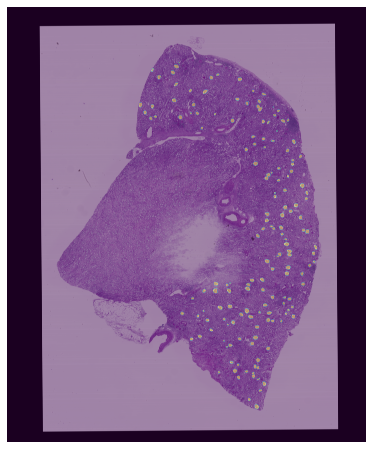

In [9]:
show_img_n_mask(df = df_masks, img_num = 0, resize = PARAMS["resize"])

In [10]:
if PARAMS["aughard"]:
    aug = albu.Compose([
        albu.OneOf([
            albu.RandomBrightness(limit = 0.2, p = 1),
            albu.RandomContrast(limit = 0.2, p = 1),
            albu.RandomGamma(p = 1)
        ], p = 0.5),
        albu.OneOf([
            albu.Blur(blur_limit = 3, p = 1),
            albu.MedianBlur(blur_limit = 3, p = 1)
        ], p = 0.25),
        albu.OneOf([
            albu.GaussNoise(0.002, p = 0.5),
            albu.IAAAffine(p = 0.5)
        ], p = 0.25),
        albu.RandomRotate90(p = 0.5),
        albu.HorizontalFlip(p = 0.5),
        albu.VerticalFlip(p = 0.5),
        albu.Cutout(num_holes = 10,
                    max_h_size = int(0.1 * size), max_w_size = int(0.1 * size),
                    p = 0.25),
        albu.ShiftScaleRotate(p = 0.25)
    ])
else:
    aug = albu.Compose([
        albu.OneOf([
            albu.RandomBrightness(limit = 0.2, p = 1),
            albu.RandomContrast(limit = 0.2, p = 1),
            albu.RandomGamma(p = 1)
        ], p = 0.5),
        albu.RandomRotate90(p = 0.25),
        albu.RandomHorizontalFlip(p = 0.25),
        albu.VerticalFlip(p = 0.25)
    ])

In [11]:
class DataGenKid(Sequence):
    
    def __init__(self, imgs_path, msks_path, imgs_idxs, img_size, 
                 batch_size = 32, mode = "fit", shuffle = False,
                 aug = None, resize = None):
        self.imgs_path = imgs_path
        self.msks_path = msks_path
        self.imgs_idxs = imgs_idxs
        self.img_size = img_size
        self.batch_size = batch_size
        self.mode = mode
        self.shuffle = shuffle
        self.aug = aug
        self.resize = resize
        self.on_epoch_end()
        
        
    def __len__(self):
        return int(np.floor(len(self.imgs_idxs) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.imgs_idxs))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def __getitem__(self, index):
        batch_size = min(self.batch_size, len(self.imgs_idxs) - index * self.batch_size)
        if (PARAMS["bnw"])&(PARAMS["triple"] == False):
            X = np.zeros((batch_size, self.img_size, self.img_size, 1), dtype = np.float32)
        else:
            X = np.zeros((batch_size, self.img_size, self.img_size, 3), dtype = np.float32)
        imgs_batch = self.imgs_idxs[index * self.batch_size : (index + 1) * self.batch_size]
        if self.mode == "fit":
            y = np.zeros((batch_size, self.img_size, self.img_size), dtype = np.float32)
            for i, img_idx in enumerate(imgs_batch):
                X[i, ], y[i] = self.get_tile(img_idx)
            return X, y
        elif self.mode == "predict":
            for i, img_idx in enumerate(imgs_batch):
                X[i, ] = self.get_tile(img_idx)
            return X
        else:
            raise AttributeError("Fit mode parameter error")
            
    def get_tile(self, img_idx):
        img_path = f"{self.imgs_path}/{img_idx}.png"
        if (PARAMS["bnw"]) & (PARAMS["triple"] == False):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = np.array(img)
            img = img.reshape(img.shape[0], img.shape[1], 1)
        else:
            img = cv2.imread(img_path)
        if img is None:
            print(f"error loading image: {image_path}")
        img = img.astype(np.float32) / 255
        if self.mode == "fit":
            msk_path = f"{self.msks_path}/{img_idx}.png"
            msk = cv2.imread(msk_path, cv2.IMREAD_GRAYSCALE)
            if msk is None:
                print(f"error loading mask: {msk_path}")
            msk = msk.astype(np.float32)
            if self.aug:
                augmented = self.aug(image = img, mask = msk)
                img = augmented["image"]
                if PARAMS["reduce_dims"]:
                    n_dims = random.randint(0, 2)
                    dims = set()
                    while len(dims) < n_dims:
                        dims.add(random.randint(0,2))
                    if len(dims) > 0:
                        img = np.transpose(img, (2,0,1))
                        for i in dims:
                            img[i] = 0
                        img = np.transpose(img, (1,2,0))
                
                msk = augmented["mask"]
            return img, msk
        else:
            if self.aug:
                img = self.aug(image = img)["image"]
            return img
        

In [12]:
PARAMS

{'version': 145,
 'folds': 5,
 'img_size': 512,
 'resize': 4,
 'batch_size': 8,
 'epochs': 1000,
 'patience': 20,
 'backbone': 'efficientnetb7',
 'loss': 'bce_jaccard_loss',
 'mirror': False,
 'umodel': 'unet',
 'bce_weight': 1.0,
 'shift': True,
 'pseudo': '',
 'lr': 0.0002,
 'split': 'dont',
 'seed': 69,
 'mixed_precision': True,
 'aughard': True,
 'norm': True,
 'bnw': True,
 'triple': True,
 'reduce_dims': False}

In [13]:
imgs_idxs = [x.replace(".png", "") for x in os.listdir(IMGS_PATH) if ".png" in x]
train_datagen = DataGenKid(
        imgs_path = IMGS_PATH,
        msks_path = MSKS_PATH,
        imgs_idxs = imgs_idxs,
        img_size = PARAMS["img_size"],
        batch_size = PARAMS["batch_size"],
        mode = "fit",
        shuffle = True,
        aug = aug,
        resize = None
)

val_datagen = DataGenKid(
        imgs_path = IMGS_PATH,
        msks_path = MSKS_PATH,
        imgs_idxs = imgs_idxs,
        img_size = PARAMS["img_size"],
        batch_size = PARAMS["batch_size"],
        mode = "fit",
        shuffle = False,
        aug = None,
        resize = None
)

In [14]:
def plot_item(item_nr):
    bsize = min(8, PARAMS["batch_size"])
    Xt, yt = train_datagen.__getitem__(item_nr)
    print("test X: ", Xt.shape)
    print("test y: ", yt.shape)
    fig, axes = plt.subplots(figsize = (16, 4), nrows = 2, ncols = bsize)
    for j in range(bsize):
        axes[0, j].imshow(Xt[j])
        axes[0, j].set_title(j)
        axes[0, j].axis("off")
        axes[1, j].imshow(yt[j])
        axes[1, j].axis("off")
    plt.show()

test X:  (8, 512, 512, 3)
test y:  (8, 512, 512)


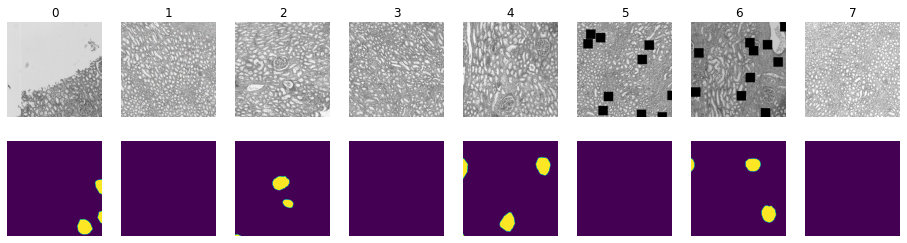

In [15]:
plot_item(25)

In [16]:
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred, smooth = 1):
    return (1 - dice_coef(y_true, y_pred, smooth))

def bce_dice_loss(y_true, y_pred):
    return PARAMS["bce_weight"] * binary_crossentropy(y_true, y_pred) + \
        (1 - PARAMS["bce_weight"]) * dice_loss(y_true, y_pred)

def get_model(backbone, input_shape, loss_type = "bce_dice",
              umodel = "unet", classes = 1, lr = .001):
    with STRATEGY.scope():
        if loss_type == "bce_dice":
            loss = bce_dice_loss
        
        elif loss_type == "bce_jaccard_loss":
            loss = bce_dice_loss
            
        else: 
            raise AttributeError("loss mode parameter error")
        
        if umodel == "unet":
            model = Unet(backbone_name = backbone, encoder_weights = "imagenet",
                         input_shape = input_shape,
                         classes = classes, activation = "sigmoid")
            
        elif umodel == "fpn":
            model = FPN(backbone_name = backbone, encoder_weights = "imagenet",
                        input_shape = input_shape,
                        classes = classes, activation = "sigmoid")
            
        elif umodel == "link":
            model = Linknet(backbone_name = backbone, encoder_weights = "imagenet",
                           input_shape = input_shape,
                           classes = classes, activation = "sigmoid")
        elif umodel == "psp":
            model = PSPNet(backbone_name = backbone, encoder_weights = "imagenet",
                          input_shape = input_shape,
                          classes = classes, activation = "sigmoid")
        
        else:
            raise AttributeError("umodel mode parameter error")
            
        if (PARAMS["bnw"])&(PARAMS["triple"] == False):
            base_model = model
            inp = Input(shape = (None, None, 1))
            l1 = Conv2D(3,(1,1))(inp) # map N channels data to 3 channels
            out = base_model(l1)
            model = Model(inp, out, name = base_model.name)
        
        model.compile(
            optimizer = tfa.optimizers.Lookahead(
                tf.keras.optimizers.Adam(learning_rate = lr),
                sync_period = max(6, int(PARAMS["patience"] / 4))
            ),
            loss = loss,
            metrics = [dice_coef]
        )
    return model

## Train

In [17]:
def train_model(mparams, n_fold, train_datagen, val_datagen):
    model = get_model(
        mparams["backbone"],
        input_shape = (mparams["img_size"], mparams["img_size"], 3),
        loss_type = mparams["loss"],
        umodel = mparams["umodel"],
        lr = mparams["lr"]
    )
    checkpoint_path = f"{MDL_PATH}/model_{n_fold}.hdf5"
    earlystopper = EarlyStopping (
        monitor = "val_dice_coef",
        patience = mparams["patience"],
        verbose = 0,
        restore_best_weights = True,
        mode = "max"
    )
    lrreducer = ReduceLROnPlateau(
        monitor = "val_dice_coef",
        factor = .5,
        patience = int(mparams["patience"] // 4),
        verbose = 0,
        min_lr = 1e-7,
        mode = "max"
    )
    checkpointer = ModelCheckpoint(
        checkpoint_path,
        monitor = "val_dice_coef",
        verbose = 0,
        save_best_only = True,
        save_weights_only = True,
        mode = "max"
    )
    callbacks = [earlystopper, checkpointer]
    callbacks.append(lrreducer)
    print("lr reduce on plateau")
    history = model.fit(
        train_datagen,
        validation_data = val_datagen,
        callbacks = callbacks,
        epochs = mparams["epochs"],
        verbose = 1
    )
    history_file = f"{MDL_PATH}/history_{n_fold}.json"
    dict_to_save = {}
    for k, v in history.history.items():
        dict_to_save.update({k: [np.format_float_positional(x) for x in history.history[k]]})
    with open(history_file, "w") as file:
        json.dump(dict_to_save, file)
    model.load_weights(checkpoint_path)
    return model, history  

  0%|          | 0/5524 [00:00<?, ?it/s]

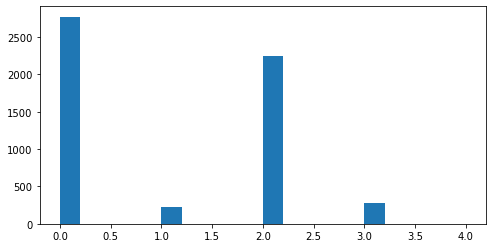

In [18]:
msks_strat = []
for img_idx in tqdm(imgs_idxs):
    msk_path = f"{MSKS_PATH}/{img_idx}.png"
    msk = cv2.imread(msk_path, cv2.IMREAD_GRAYSCALE)
    msk_max = PARAMS["img_size"] ** 2
    if np.sum(msk) == 0:
        msk_cls = 0
    elif np.sum(msk) < msk_max * 0.01:
        msk_cls = 1
    elif np.sum(msk) < msk_max * 0.1:
        msk_cls = 2
    elif np.sum(msk) < msk_max * 0.2:
        msk_cls = 3
    elif np.sum(msk) < msk_max * 0.3:
        msk_cls = 4
    else:
        msk_cls = 5
    msks_strat.append(msk_cls)
plt.figure(figsize = (8,4))
plt.hist(msks_strat, bins = 20)
plt.show()

In [19]:
for iname in list(set([x[:9] for x in imgs_idxs])):
    print("img name:", iname,
          "| imgs number:", len([x for x in imgs_idxs if x[:9] == iname]))
if PARAMS["split"] == "kfold":
    kfold = KFold(n_splits = PARAMS["folds"],
                  random_state = PARAMS["seed"],
                  shuffle = True).split(imgs_idxs)
elif PARAMS["split"] == "dont":
    kfold = kfold = KFold(n_splits = 5,
                  random_state = PARAMS["seed"],
                  shuffle = True).split(imgs_idxs)
    PARAMS["folds"] = 1
elif PARAMS["split"] == "strat":
    kfold = StratifiedKFold(n_splits = PARAMS["folds"],
                           random_state = PARAMS["seed"],
                           shuffle = True).split(imgs_idxs, msks_strat)
else:
    raise AttributeError("split mode parameter error")

img name: b9a3865fc | imgs number: 452
img name: b2dc8411c | imgs number: 128
img name: 0486052bb | imgs number: 215
img name: cb2d976f4 | imgs number: 517
img name: 4ef6695ce | imgs number: 688
img name: 8242609fa | imgs number: 452
img name: aaa6a05cc | imgs number: 85
img name: 2f6ecfcdf | imgs number: 190
img name: c68fe75ea | imgs number: 645
img name: e79de561c | imgs number: 187
img name: 26dc41664 | imgs number: 448
img name: 1e2425f28 | imgs number: 328
img name: 095bf7a1f | imgs number: 384
img name: 54f2eec69 | imgs number: 173
img name: afa5e8098 | imgs number: 632


========== FOLD 0 ==========
train: 4419 | test: 1105
groups train: {'b9a3865fc', 'b2dc8411c', '0486052bb', 'cb2d976f4', '4ef6695ce', '8242609fa', 'aaa6a05cc', '2f6ecfcdf', 'c68fe75ea', 'e79de561c', '26dc41664', '1e2425f28', '095bf7a1f', '54f2eec69', 'afa5e8098'} 
groups test: {'b9a3865fc', 'b2dc8411c', '0486052bb', 'cb2d976f4', '4ef6695ce', '8242609fa', 'aaa6a05cc', '2f6ecfcdf', 'c68fe75ea', 'e79de561c', '26dc41664', '1e2425f28', '095bf7a1f', '54f2eec69', 'afa5e8098'}
lr reduce on plateau
Epoch 1/1000
552/552 [==============================] - 623s 940ms/step - loss: 0.3645 - dice_coef: 0.1156 - val_loss: 0.0720 - val_dice_coef: 0.3063
Epoch 2/1000
552/552 [==============================] - 500s 905ms/step - loss: 0.0692 - dice_coef: 0.3478 - val_loss: 0.0323 - val_dice_coef: 0.5498
Epoch 3/1000
552/552 [==============================] - 502s 909ms/step - loss: 0.0349 - dice_coef: 0.5023 - val_loss: 0.0205 - val_dice_coef: 0.6585
Epoch 4/1000
552/552 [==============================] -

552/552 [==============================] - 502s 910ms/step - loss: 0.0061 - dice_coef: 0.8246 - val_loss: 0.0080 - val_dice_coef: 0.8609
Epoch 53/1000
552/552 [==============================] - 504s 912ms/step - loss: 0.0059 - dice_coef: 0.8116 - val_loss: 0.0080 - val_dice_coef: 0.8614
Epoch 54/1000
552/552 [==============================] - 502s 909ms/step - loss: 0.0061 - dice_coef: 0.8140 - val_loss: 0.0079 - val_dice_coef: 0.8633
Epoch 55/1000
552/552 [==============================] - 502s 909ms/step - loss: 0.0063 - dice_coef: 0.8165 - val_loss: 0.0079 - val_dice_coef: 0.8634
Epoch 56/1000
552/552 [==============================] - 501s 907ms/step - loss: 0.0059 - dice_coef: 0.8216 - val_loss: 0.0081 - val_dice_coef: 0.8633
Epoch 57/1000
552/552 [==============================] - 502s 909ms/step - loss: 0.0064 - dice_coef: 0.8267 - val_loss: 0.0080 - val_dice_coef: 0.8630
Epoch 58/1000
552/552 [==============================] - 502s 909ms/step - loss: 0.0060 - dice_coef: 0.8253 

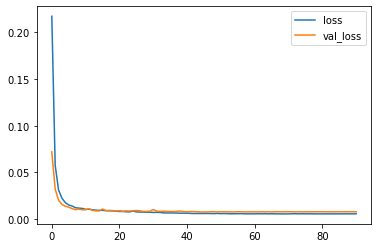

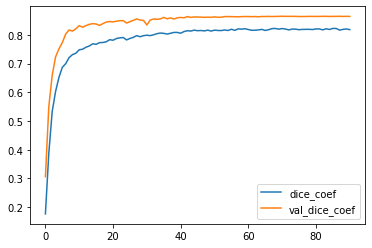

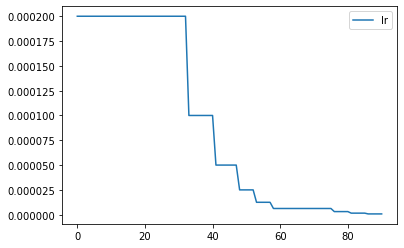

best epoch: 70 | best loss: 0.008067846298217773 | best dice coef: 0.8646036982536316
time elapsed: 764 min 17 sec


In [20]:
epoch_by_folds = []
loss_by_folds = []
dice_coef_by_folds = []

for n, (tr, te) in enumerate(kfold):
    print("=" * 10, f"FOLD {n}", "=" * 10)
    X_tr = [imgs_idxs[i] for i in tr]; X_val = [imgs_idxs[i] for i in te]
    print("train:", len(X_tr), "| test:", len(X_val))
    print("groups train:", set([x[:9] for x in X_tr]),
          "\ngroups test:", set([x[:9] for x in X_val]))
    train_datagen = DataGenKid(
        imgs_path = IMGS_PATH,
        msks_path = MSKS_PATH,
        imgs_idxs = X_tr,
        img_size = PARAMS["img_size"],
        batch_size = PARAMS["batch_size"],
        mode = "fit",
        shuffle = True,
        aug = aug,
        resize = None
    )
    
    val_datagen = DataGenKid(
        imgs_path = IMGS_PATH,
        msks_path = MSKS_PATH,
        imgs_idxs = X_val,
        img_size = PARAMS["img_size"],
        batch_size = PARAMS["batch_size"],
        mode = "fit",
        shuffle = False,
        aug = None,
        resize = None
    )
    model, history = train_model(PARAMS, n, train_datagen, val_datagen)
    
    plt.plot(history.history["loss"], label = "loss")
    plt.plot(history.history["val_loss"], label = "val_loss")
    plt.legend()
    plt.show()
    plt.plot(history.history["dice_coef"], label = "dice_coef")
    plt.plot(history.history["val_dice_coef"], label = "val_dice_coef")
    plt.legend()
    plt.show()
    plt.plot(history.history["lr"], label = "lr")
    plt.legend()
    plt.show()
    best_epoch = np.argmax(history.history["val_dice_coef"])
    best_loss = history.history["val_loss"][best_epoch]
    best_dice_coef = history.history["val_dice_coef"][best_epoch]
    print("best epoch:", best_epoch,
         "| best loss:", best_loss,
         "| best dice coef:", best_dice_coef)
    epoch_by_folds.append(best_epoch)
    loss_by_folds.append(best_loss)
    dice_coef_by_folds.append(best_dice_coef)
    del train_datagen, val_datagen, model; gc.collect()
    if PARAMS["split"] == "dont":
        break

elapsed_time = time.time() - start_time
print(f"time elapsed: {elapsed_time // 60:.0f} min {elapsed_time % 60:.0f} sec")

In [21]:
PARAMS["folds"] = len(glob(f"{MDL_PATH}/history_*.json"))

In [22]:
result = PARAMS.copy()
result["bavg_epoch"] = np.mean(epoch_by_folds)
result["bavg_loss"] = np.mean(loss_by_folds)
result["bavg_dice_coef"] = np.mean(dice_coef_by_folds)
result["dice_by_folds"] = " ".join([f"{x:.4f}" for x in dice_coef_by_folds])
with open(f"{MDL_PATH}/params.json", "w") as file:
    json.dump(result, file)
if not os.path.exists(f"{MDLS_PATH}/results.csv"):
    df_save = pd.DataFrame(result, index = [0])
    df_save.to_csv(f"{MDLS_PATH}/results.csv")
else:
    df_old = pd.read_csv(f"{MDLS_PATH}/results.csv", index_col = 0)
    df_save = pd.DataFrame(result, index = [df_old.index.max() + 1])
    df_save = df_old.append(df_save, ignore_index = True)
    df_save.to_csv(f"{MDLS_PATH}/results.csv",)

In [23]:
pd.read_csv(f"{MDLS_PATH}/results.csv", index_col = [0])

,version,folds,img_size,resize,batch_size,epochs,patience,backbone,loss,mirror,umodel,bce_weight,shift,pseudo,lr,best_epoch,best_loss,best_dice_coef,split,seed,bavg_epoch,bavg_loss,bavg_dice_coef,dice_by_folds,mixed_precision,aughard,norm,bnw,weights,triple,reduce_dims
0,6,1,256,1,20,30,20,efficientnetb7,bce_dice,False,unet,1.0,True,NaN,0.0002,25.0,0.004156,0.894248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13,4,256,1,32,40,20,efficientnetb7,bce_dice,False,unet,1.0,True,NaN,0.0002,NaN,NaN,NaN,kfold,NaN,15.500000,0.236562,0.454637,0.6554 0.4974 0.5797 0.0861,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14,4,256,4,32,40,20,efficientnetb7,bce_dice,False,unet,1.0,True,NaN,0.0010,NaN,NaN,NaN,kfold,NaN,24.666667,NaN,NaN,nan 0.2318 0.3154,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,22,1,256,4,64,1,20,efficientnetb0,bce_dice,False,unet,1.0,True,NaN,0.0001,NaN,NaN,NaN,dont,NaN,0.000000,0.516637,0.077527,0.0775,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,24,1,256,4,32,20,20,efficientnetb0,bce_dice,False,unet,1.0,True,NaN,0.0001,NaN,NaN,NaN,dont,42.0,15.000000,0.027320,0.777308,0.7773,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,25,1,256,4,32,20,20,efficientnetb0,bce_dice,False,unet,1.0,True,NaN,0.0001,NaN,NaN,NaN,dont,42.0,19.000000,0.019676,0.884997,0.8850,False,NaN,NaN,NaN,NaN,NaN,NaN
6,17,4,256,4,16,30,20,efficientnetb5,bce_dice,False,unet,1.0,True,NaN,0.0002,NaN,NaN,NaN,kfold,NaN,13.000000,0.083721,0.637541,0.8200 0.8174 0.1290 0.7837,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,27,1,256,4,32,20,10,efficientnetb0,bce_dice,False,unet,1.0,True,NaN,0.0001,NaN,NaN,NaN,dont,69.0,16.000000,0.033654,0.662921,0.6629,True,NaN,NaN,NaN,NaN,NaN,NaN
8,31,1,256,4,32,20,10,efficientnetb0,bce_dice,False,unet,1.0,True,NaN,0.0001,NaN,NaN,NaN,dont,69.0,11.000000,0.073768,0.667674,0.6677,True,NaN,NaN,NaN,NaN,NaN,NaN
9,26,1,256,4,32,100,10,efficientnetb0,bce_dice,False,unet,1.0,True,NaN,0.0001,NaN,NaN,NaN,dont,42.0,46.000000,0.025203,0.899880,0.8999,False,NaN,NaN,NaN,NaN,NaN,NaN


## Predict

In [24]:
larger = 4
test_models = []
for n_fold in list(range(PARAMS["folds"])):
    
    checkpoint_path = f"{MDL_PATH}/model_{n_fold}.hdf5"
    print(checkpoint_path)
    model_lrg = get_model (
        PARAMS["backbone"],
        input_shape = (PARAMS["img_size"] * larger, PARAMS["img_size"] * larger, 3),
        loss_type = PARAMS["loss"],
        umodel = PARAMS["umodel"]
    )
    model_lrg.load_weights(checkpoint_path) # or .set_weights(model.get_weights()) from smaller model
    test_models.append(model_lrg)

../models/models_v145/model_0.hdf5


(31278, 25794, 3) (31278, 25794)
(2048, 2048, 3)


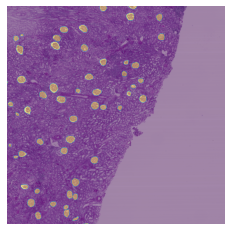

In [25]:
img_num = 0
resize = PARAMS["resize"]
shft = 0.6
wnd = PARAMS["img_size"] * larger
img = tiff.imread(os.path.join(f"{DATA_PATH}/train", df_masks.index[img_num] + ".tiff"))
if len(img.shape) == 5: img = np.transpose(img.squeeze(), (1, 2, 0))
mask = enc2mask(df_masks.iloc[img_num], (img.shape[1], img.shape[0]))
print(img.shape, mask.shape)
img = cv2.resize(img,
                 (img.shape[1] // resize, img.shape[0] // resize),
                 interpolation = cv2.INTER_AREA)
mask = cv2.resize(mask,
                  (mask.shape[1] // resize, mask.shape[0] // resize),
                  interpolation = cv2.INTER_NEAREST)
img = img[int(img.shape[0] * shft) : int(img.shape[0] * shft) + wnd,
          int(img.shape[1] * shft) : int(img.shape[1] * shft) + wnd,
          :]
mask = mask[int(mask.shape[0] * shft) : int(mask.shape[0] * shft) + wnd,
            int(mask.shape[1] * shft) : int(mask.shape[1] * shft) + wnd]
plt.figure(figsize = (4, 4))
plt.axis("off")
plt.imshow(img)
print(img.shape)
plt.imshow(mask, alpha = 0.4)
plt.show()

In [26]:
def dice_np(pred, true, k = 1):
    intersection = np.sum(pred[true == k]) * 2
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

def get_dice(mask, mask_lrg, th):
    mask_pred = np.squeeze(mask_lrg > th).astype(int)
    return dice_np(mask, mask_pred)

def get_best_th_dice(mask, mask_lrg, n=100, plot = False):
    thresholds = np.linspace(0, 1, n)
    dices = [get_dice(mask, mask_lrg, th) for th in thresholds]
    n_max = np.argmax(dices)
    if plot:
        plt.plot(thresholds, dices)
        plt.title(f"th: {thresholds[n_max]:.2f} dice: {dices[n_max]:.2f}")
        plt.show()
    return thresholds, dices, n_max

In [27]:
masks_lrg = []
for j in range(len(test_models)):
    mask_lrg = test_models[j].predict(img[np.newaxis, ] / 255).astype(np.float32)
    masks_lrg.append(mask_lrg)

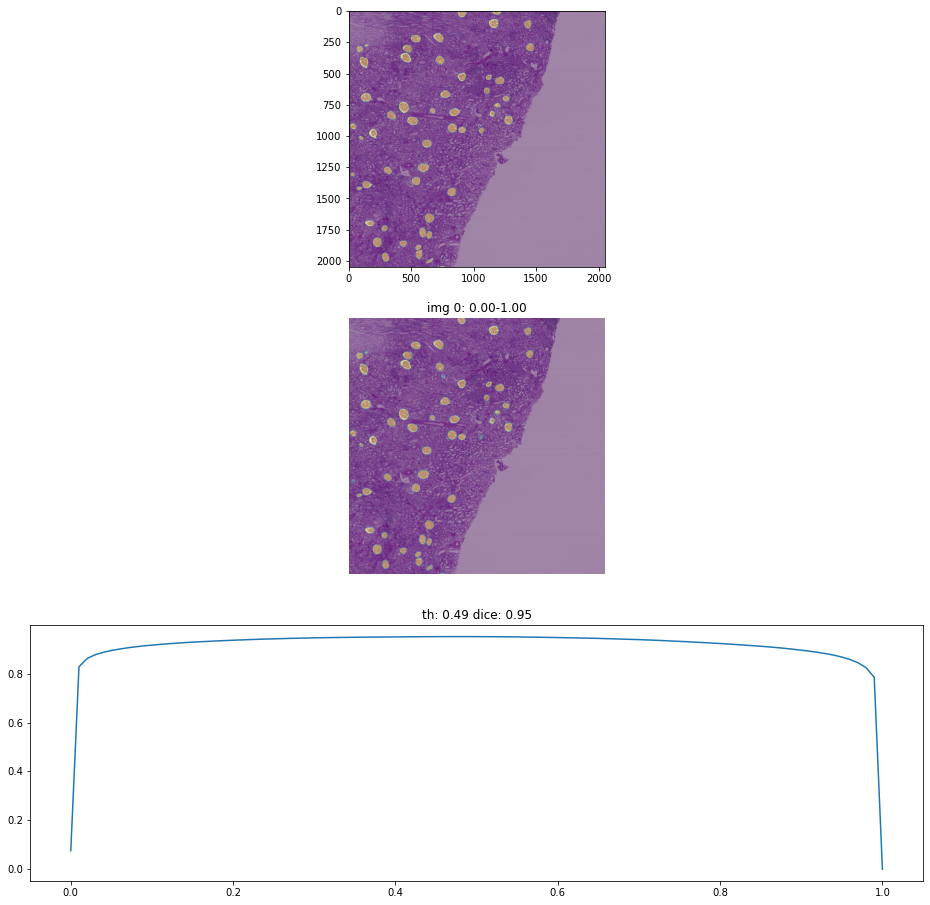

In [28]:
fig, axes = plt.subplots(figsize = (16, 16), nrows = 3, ncols = len(test_models))
if len(test_models) == 1:
    for j in range(len(test_models)):
        mask_lrg = masks_lrg[j]
        axes[0].imshow(img)
        axes[0].imshow(mask, alpha = 0.4)
        axes[1].imshow(img)
        axes[1].imshow(np.squeeze(mask_lrg), alpha = 0.4)
        axes[1].set_title(f"img {j}: {np.min(mask_lrg):.2f}-{np.max(mask_lrg):.2f}")
        axes[1].axis("off")
        thresholds,dices, n_max = get_best_th_dice(mask, mask_lrg, n=100, plot = False)
        axes[2].plot(thresholds, dices)
        axes[2].set_title(f"th: {thresholds[n_max]:.2f} dice: {dices[n_max]:.2f}")
    plt.show()
else:
    for j in range(len(test_models)):
        mask_lrg = masks_lrg[j]
        axes[0,j].imshow(img)
        axes[0,j].imshow(mask, alpha = 0.4)
        axes[1,j].imshow(img)
        axes[1,j].imshow(np.squeeze(mask_lrg), alpha = 0.4)
        axes[1,j].set_title(f"img {j}: {np.min(mask_lrg):.2f}-{np.max(mask_lrg):.2f}")
        axes[1,j].axis("off")
        thresholds,dices, n_max = get_best_th_dice(mask, mask_lrg, n=100, plot = False)
        axes[2,j].plot(thresholds, dices)
        axes[2,j].set_title(f"th: {thresholds[n_max]:.2f} dice: {dices[n_max]:.2f}")
    plt.show()
    

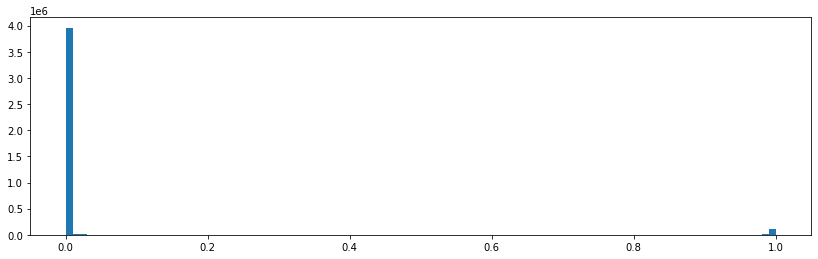

In [29]:
for mask_lrg in masks_lrg:
    plt.figure(figsize = (14, 4))
    plt.hist(mask_lrg.flatten(), bins = 100)
    plt.show()

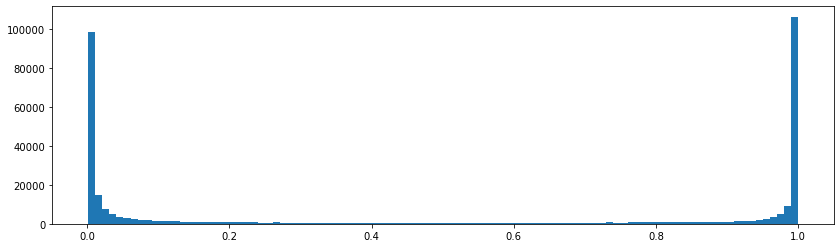

In [30]:
for mask_lrg in masks_lrg:
    plt.figure(figsize = (14, 4))
    plt.hist(np.where(mask_lrg < 10e-4, np.nan, mask_lrg).flatten(), bins = 100)
    plt.show()